In [ ]:
# !pip install nb_black
# %load_ext lab_black

# Планирование рекламной кампании для сферы видеоигр

Мы в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

In [ ]:
import pandas as pd
import numpy as np
import math
import scipy
import plotly.graph_objects as go
from matplotlib.ticker import (
    PercentFormatter,
)  # чтоб оси на графике превращать в проценты
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

In [ ]:
# чтение датасета
spreadsheet_id = "1e8NhBrjn9dmoLvBNtDMLW_u4HTjDgfpTod873bIw1zQ"
file_name = "https://docs.google.com/spreadsheets/d/{}/export?format=csv".format(
    spreadsheet_id
)
r = requests.get(file_name)
df_raw = pd.read_csv(BytesIO(r.content))

In [ ]:
# установка параметров системы
pd.options.display.max_columns = 100  # чтоб выводил все столбцы на экран
np.seterr(divide="ignore", invalid="ignore")
plt.rcParams["figure.figsize"] = (
    12,
    6,
)  # установить единый размер графиков по умолчанию

## Изучение данных

Получим общую информацию о таблице:

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Итак, согласно документации к данным:

    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). 
    Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.


В названиях колонок видны нарушения стиля. Разберемся с ними на этапе предобработки данных.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.


Выведем на экран первые пять строк таблицы:

In [ ]:
df_raw.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим, какие строки имеют пропуски в столбце `Name`:


In [ ]:
df_raw[df_raw["Name"].isna()]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пожалуй, эти строки можно будет исключить. Так как в этих строчках много пропусков, а удаление 2х строк не сильно повлияет на дальнейший анализ.

В столбце с рейтингом от ESRB встречаются очень много пропусков.
ESRB это Американское рейтингое агенство. Кроме этой ассоциации, в мире существует множество других организаций, которые присваивают рейтинг играм и иногда имеют сильное юридическое влияние на выпуск игры, в отличие от того же рейтинга ESRB, присвоение которого не является юридически обязательным действием для выпуска игры ни Северной Америке, ни где-либо еще. 

В принципе, получение рейтинга ESRB — дело добровольное. Однако для обеспечения успеха официальных продаж компьютерной игры на территории США и Канады рейтинг ей просто необходим. Без такой оценки издатели сталкиваются со многими ограничениями, заложенными в корпоративную политику крупнейших торговых сетей Соединенных штатов. 

Учитывая все эти факты, если игра нацелена в первую очередь на Северо-Американский рынок, издателю крайне желательно получение рейтинга, если нет - то от процедуры присвоения рейтинга этого агенства можно отказаться. И, вероятно, многие издатели отказываются. Этим, я считаю, объясняется такое большое количество пропусков в столбце `Rating` <a id='esrb_nan'></a>    

Пропуски в столбцах с оценкой пользователей и критиков могут быть объяснены тем, что сайт-агрегатор Metacritic, откуда, вероятно, была получена эта информация, не охватывает все платформы представленные в датасете. <a id='crit_nan'></a>   

Посмотрим, какие виды значений в столбце `Year_of_Release`:

In [ ]:
df_raw["Year_of_Release"].describe()

count    16446.000000
mean      2006.484616
std          5.877050
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: Year_of_Release, dtype: float64

Мы имеем данные с 1980 по 2016 год.

Значения этого столбца можно привести к типу int32 для ускорения работы с таблицей.

Посмотрим, какие виды значений в столбце `Genre`:

In [ ]:
df_raw["Genre"].value_counts().sort_values()

Puzzle           580
Strategy         683
Fighting         849
Simulation       873
Platform         888
Racing          1249
Adventure       1303
Shooter         1323
Role-Playing    1498
Misc            1750
Sports          2348
Action          3369
Name: Genre, dtype: int64

Проблем нет.

Построим гистограммы для числовых данных таблиц:

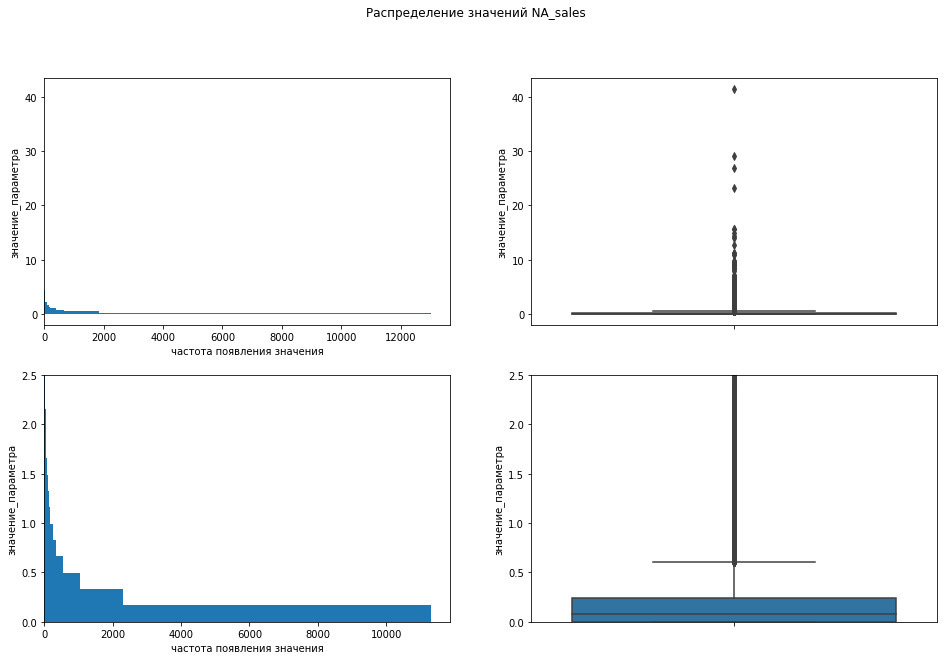

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Распределение значений NA_sales")
y = df_raw["NA_sales"]
ax[0, 0].set_xlabel("частота появления значения")
ax[0, 0].set_ylabel("значение_параметра")
ax[0, 1].set_ylabel("значение_параметра")
ax[0, 0].hist(y, orientation="horizontal", bins=150)
sns.boxplot(data=y, orient="v", ax=ax[0, 1])
ax[0, 1].set_xticklabels([])
ax[1, 0].set_xlabel("частота появления значения")
ax[1, 0].set_ylabel("значение_параметра")
ax[1, 0].hist(y, orientation="horizontal", bins=250)
ax[1, 0].set_ylim([0, 2.5])
ax[1, 1].set_ylabel("значение_параметра")
sns.boxplot(data=y, orient="v", ax=ax[1, 1])
ax[1, 1].set_ylim([0, 2.5])
ax[1, 1].set_xticklabels([])
plt.show()

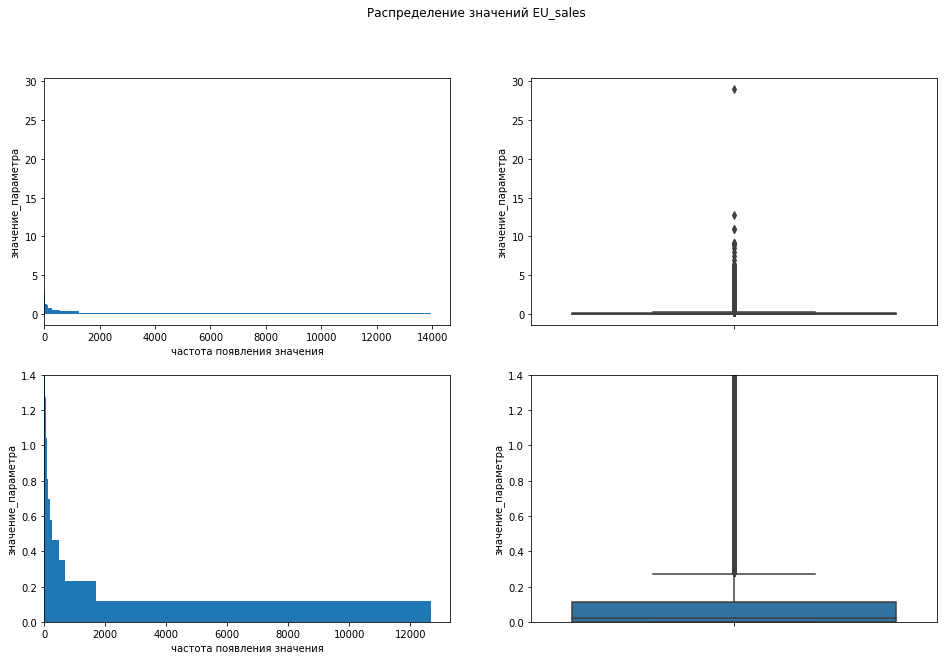

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Распределение значений EU_sales")
y = df_raw["EU_sales"]
ax[0, 0].set_xlabel("частота появления значения")
ax[0, 0].set_ylabel("значение_параметра")
ax[0, 1].set_ylabel("значение_параметра")
ax[0, 0].hist(y, orientation="horizontal", bins=150)
sns.boxplot(data=y, orient="v", ax=ax[0, 1])
ax[0, 1].set_xticklabels([])
ax[1, 0].set_xlabel("частота появления значения")
ax[1, 0].set_ylabel("значение_параметра")
ax[1, 0].hist(y, orientation="horizontal", bins=250)
ax[1, 0].set_ylim([0, 1.4])
ax[1, 1].set_ylabel("значение_параметра")
sns.boxplot(data=y, orient="v", ax=ax[1, 1])
ax[1, 1].set_ylim([0, 1.4])
ax[1, 1].set_xticklabels([])
plt.show()

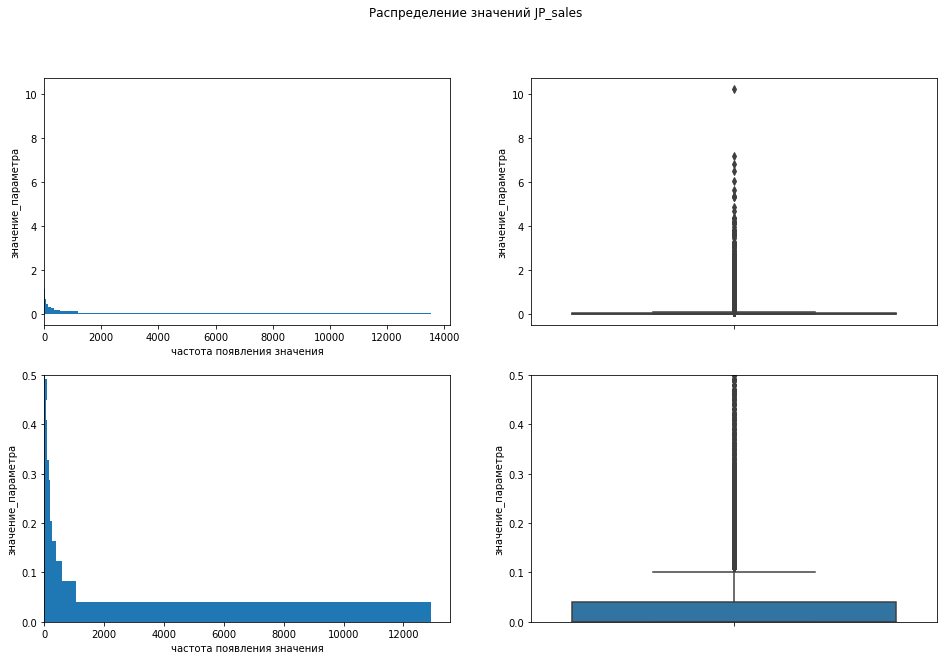

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Распределение значений JP_sales")
y = df_raw["JP_sales"]
ax[0, 0].set_xlabel("частота появления значения")
ax[0, 0].set_ylabel("значение_параметра")
ax[0, 1].set_ylabel("значение_параметра")
ax[0, 0].hist(y, orientation="horizontal", bins=150)
sns.boxplot(data=y, orient="v", ax=ax[0, 1])
ax[0, 1].set_xticklabels([])
ax[1, 0].set_xlabel("частота появления значения")
ax[1, 0].set_ylabel("значение_параметра")
ax[1, 0].hist(y, orientation="horizontal", bins=250)
ax[1, 0].set_ylim([0, 0.5])
ax[1, 1].set_ylabel("значение_параметра")
sns.boxplot(data=y, orient="v", ax=ax[1, 1])
ax[1, 1].set_ylim([0, 0.5])
ax[1, 1].set_xticklabels([])
plt.show()

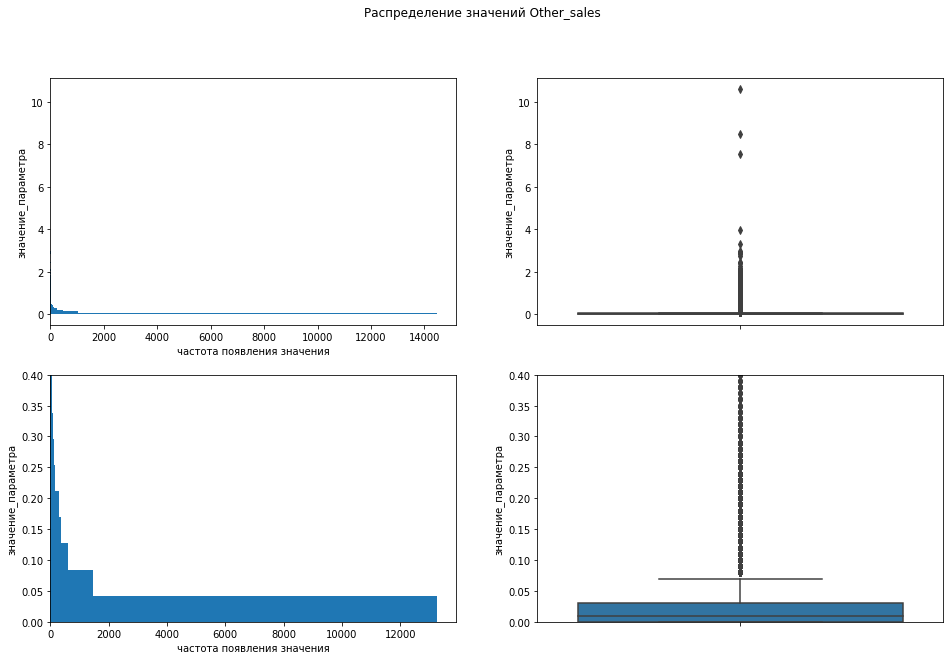

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Распределение значений Other_sales")
y = df_raw["Other_sales"]
ax[0, 0].set_xlabel("частота появления значения")
ax[0, 0].set_ylabel("значение_параметра")
ax[0, 1].set_ylabel("значение_параметра")
ax[0, 0].hist(y, orientation="horizontal", bins=150)
sns.boxplot(data=y, orient="v", ax=ax[0, 1])
ax[0, 1].set_xticklabels([])
ax[1, 0].set_xlabel("частота появления значения")
ax[1, 0].set_ylabel("значение_параметра")
ax[1, 0].hist(y, orientation="horizontal", bins=250)
ax[1, 0].set_ylim([0, 0.4])
ax[1, 1].set_ylabel("значение_параметра")
sns.boxplot(data=y, orient="v", ax=ax[1, 1])
ax[1, 1].set_ylim([0, 0.4])
ax[1, 1].set_xticklabels([])
plt.show()

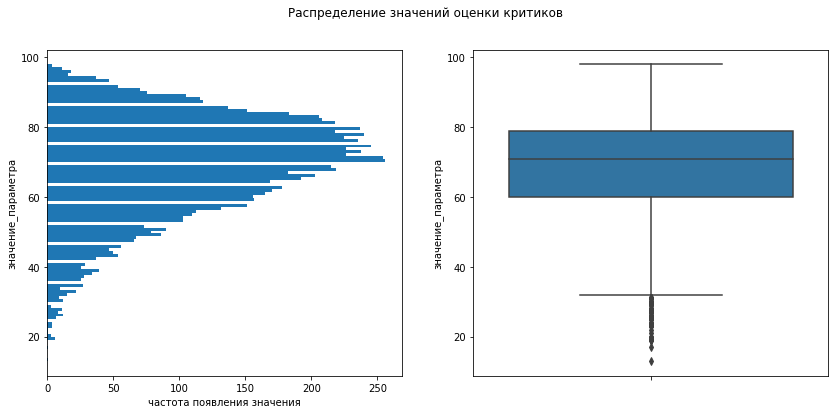

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Распределение значений оценки критиков")
y = df_raw["Critic_Score"]
ax1.set_xlabel("частота появления значения")
ax1.set_ylabel("значение_параметра")
ax2.set_ylabel("значение_параметра")
ax1.hist(y, orientation="horizontal", bins=100)
sns.boxplot(data=y, orient="v", ax=ax2)
ax2.set_xticklabels([])
plt.show()

Проблемы в числовых данных не обнаружены.

Посмотрим разброс значений в столбцах с числовыми данными:

In [ ]:
df_raw.loc[:, ["NA_sales", "EU_sales", "JP_sales", "Other_sales", "Critic_Score"]].agg(
    ["min", "max"]
)

,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
min,0.00,0.00,0.00,0.00,13.0
max,41.36,28.96,10.22,10.57,98.0


Проверим, много ли нулей в стобцах в процентном соотношении к общему количеству дотсупных данных:

In [ ]:
df_raw.select_dtypes(exclude=["object", "bool"]).eq(0).sum() / len(df_raw)

Year_of_Release    0.000000
NA_sales           0.269698
EU_sales           0.351182
JP_sales           0.629016
Other_sales        0.394915
Critic_Score       0.000000
dtype: float64

In [ ]:
df_raw.select_dtypes(exclude=["object", "bool"]).eq(0.01).sum() / len(df_raw)

Year_of_Release    0.000000
NA_sales           0.032605
EU_sales           0.089381
JP_sales           0.042238
Other_sales        0.207239
Critic_Score       0.000000
dtype: float64

Столбец `User_Score` отображается как столбец с типом данных object, а должен быть с числовым типом. Проверим какие значения в нем встречаются:

In [ ]:
df_raw["User_Score"].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: User_Score, Length: 96, dtype: int64

В столбце встречаются значения 'tbd', что означает - "подлежит определению". По сути, эти значения неопределенные. Их можно заменить пропусками на этапе предобработки.

***Вывод***

У нас в распоряжении одна таблица с набором данных содержащих информацию о более чем 16 000 различных консольных видеоигр, начиная с 1980-х годов и заканчивая 2016 годом.

Есть довольно много пропусков данных, особенно в отношении оценок критиков и пользователей.

Предварительно можно утверждать, что, данных достаточно для проведения исследования. 
Из проблем, обнаружены неподходящие для анализа типы данных и пропуски. Требуется предобработка перед тем как приступить непосредственно к вычислениям и исследовательскому анализу.



## Предобработка данных

### Стиль заголовков


In [ ]:
df = df_raw.copy()  # создадим копию таблицы на всякий случай

Для начала приведем названия колонок к нижнему регистру:

In [ ]:
df.columns = df.columns.str.lower()  # изменение столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Проверка явных дубликатов

Проверим, есть ли явные дубликаты в данных:

In [ ]:
df.duplicated().sum()

0

### Проверка неявных дубликатов

Проверим, есть ли неявные дубликаты в столбце `name`. Для  этого приведем названия к нижнему регистру и посчитаем совпадения:

In [ ]:
df["name"] = df["name"].str.lower()
df["name"].duplicated().sum()

5155

In [ ]:
df['jp_sales'] = df['jp_sales']*1.0000
df['jp_sales']

0         3.77
1         6.81
2         3.79
3         3.28
4        10.22
         ...  
16710     0.01
16711     0.00
16712     0.01
16713     0.00
16714     0.01
Name: jp_sales, Length: 16715, dtype: float64

Выведем таблицу:

In [ ]:
df[df["name"].duplicated(keep=False)].sort_values(by="name").head(12)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
9507,007: quantum of solace,DS,2008.0,Action,0.11,0.01,0.00,0.01,65.0,tbd,T
14658,007: quantum of solace,PC,2008.0,Action,0.01,0.01,0.00,0.00,70.0,6.3,T
3120,007: quantum of solace,Wii,2008.0,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
1785,007: quantum of solace,PS3,2008.0,Action,0.43,0.51,0.02,0.19,65.0,6.6,T
1285,007: quantum of solace,X360,2008.0,Action,0.82,0.51,0.01,0.14,65.0,7.1,T
4475,007: quantum of solace,PS2,2008.0,Action,0.17,0.00,0.00,0.26,NaN,NaN,NaN
1204,007: the world is not enough,N64,2000.0,Action,1.13,0.38,0.02,0.03,NaN,NaN,NaN
2243,007: the world is not enough,PS,2000.0,Action,0.51,0.35,0.00,0.06,61.0,6.7,T
15091,11eyes: crossover,X360,2009.0,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
15656,11eyes: crossover,PSP,2010.0,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN


Одна и та же игра выходила на разных платформах. Удалять эти дубликаты не требуется.
Но, проверим, есть ли задублированные значения сразу в двух колонках (имя и платформа):

In [ ]:
df[df[["name", "platform"]].duplicated(keep=False)].sort_values(by="name")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
16230,madden nfl 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E
1190,need for speed: most wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,need for speed: most wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
5972,need for speed: most wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,need for speed: most wanted,PC,2012.0,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
1745,sonic the hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,sonic the hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Похоже, игры с разными годами появления - это переиздания прошлых версий игр. Оставим их в покое. 

Другое дело - игры с одним годом выхода. Причина появления этих задвоений неизвестна. Удаление этих данных не сильно повлияет на дальнейший анализ. Оставим только те строки, в которых самое большое значение по продажам в Северной Америке. 

In [ ]:
df["year_of_release"] = df["year_of_release"].fillna(
    0
)  # заполняем пропуски, чтобы провести группировку. по сути костыль
df = df.groupby(
    ["name", "platform", "year_of_release"], sort=False, as_index=False
).apply(lambda x: x.loc[x["total_sales"].idxmax()])
df["year_of_release"] = df["year_of_release"].where(
    df["year_of_release"] != 0, np.nan
)  # возвращаем пропуски

### Работа с пропусками

Удалим строки с ранее намеченным планом:

In [ ]:
df = df.dropna(
    subset=["name"]
).copy()  # строк на самом деле уже нет после последней группировки

____________________

Заменим пропусками значения 'tbd' в столбце `user_score`:

In [ ]:
df.loc[:, "user_score"] = df.loc[:, "user_score"].where(
    df.loc[:, "user_score"] != "tbd", np.nan
)
df.loc[:, "user_score"] = df.loc[:, "user_score"].astype(float)

Теперь можно провести анализ значений столбца:

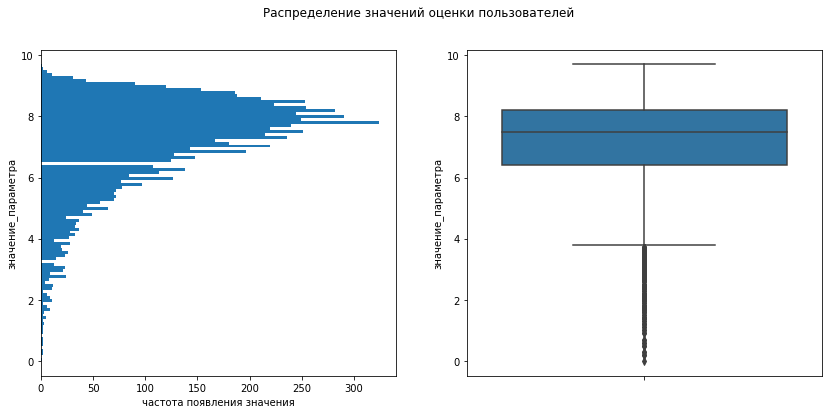

min    0.0
max    9.7
Name: user_score, dtype: float64

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Распределение значений оценки пользователей")
y = df["user_score"]
ax1.set_xlabel("частота появления значения")
ax1.set_ylabel("значение_параметра")
ax2.set_ylabel("значение_параметра")
ax1.hist(y, orientation="horizontal", bins=100)
sns.boxplot(data=y, orient="v", ax=ax2)
ax2.set_xticklabels([])
plt.show()
df["user_score"].agg(["min", "max"])

Со значениями все в порядке.

___________________________________

В столбце `year_of_release` есть пропуски. Для начала посмотрим, есть ли закономерность в распределении строк с пропусками в базе данных:

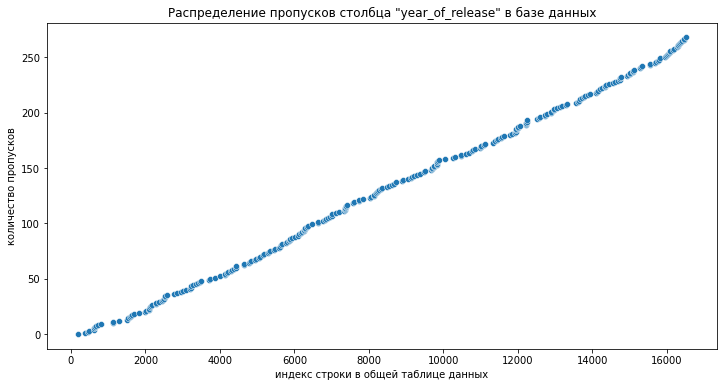

In [ ]:
sns.scatterplot(
    x=df_raw[df_raw.loc[:, "Year_of_Release"].isna()].index.tolist(),
    y=range(len(df_raw[df_raw["Year_of_Release"].isna()])),
)
plt.xlabel("индекс строки в общей таблице данных")
plt.ylabel("количество пропусков")
plt.title('Распределение пропусков столбца "year_of_release" в базе данных')
plt.show()

Пропуски распределены случайным образом.

В столбце с названием игры, в конце названия зачастую пишется год выпуска игры. Давайте проверим это. 

Сначала отработаем вариант, где в названии пишется 4х-значное число, обозначающее год издания игры.

Создадим список с диапазоном лет датасета:

In [ ]:
lst = list(range(1980, 2017))
lst = [str(x) for x in lst]  # конвертируем числа в строки

Создадим паттерн и будем сравнивать с ним название игры.

In [ ]:
pattern = "|".join(
    lst
)  # преобразуем список в строчку чтобы оператор мог зацепиться за одно число из этой строчки
pattern

'1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016'

Создадим столбец `year` куда будем помещать найденные в названии игры числовые данные содержащие год из нашего диапазона:

In [ ]:
df.loc[:, "year"] = (
    df.loc[df["name"].str.contains(pattern), "name"]
    .astype("str")
    .str.extractall("(\d+)")
    .unstack()
    .fillna("")
    .sum(axis=1)
    .astype(int)
)
df.loc[df["year"].notna(), "year"]

87         2015.0
183        2004.0
238        2005.0
250        2007.0
283        2003.0
           ...   
16635      2014.0
16655      2011.0
16673    142008.0
16708      2007.0
16711     82016.0
Name: year, Length: 832, dtype: float64

Некоторые числовые данные смешались с годом. Отделим их, выбрав последние 4 цифры:

In [ ]:
df.loc[:, "year"] = df.loc[:, "year"].fillna(0)
df.loc[:, "year"] = df.loc[:, "year"].astype(int)
df.loc[:, "year"] = df.loc[:, "year"].apply(
    lambda x: str(x)[-4:]
)  # забираем последние 4 цифры
df.loc[:, "year"] = df.loc[:, "year"].astype(int)

In [ ]:
lst = [int(x) for x in lst]
df.loc[:, "year"] = df.loc[
    df.loc[:, "year"].isin(lst), "year"
]  # сверяем еще раз, что эти 4 цифры соответствуют нашему диапазону
df.loc[:, "year"].value_counts()

2002.0    79
2010.0    67
2000.0    63
2004.0    61
2005.0    52
2003.0    51
2009.0    50
2014.0    49
2001.0    49
2011.0    49
2008.0    46
2015.0    40
2016.0    39
2012.0    37
2013.0    32
2006.0    31
2007.0    27
1996.0     2
1999.0     2
Name: year, dtype: int64

In [ ]:
df["year_of_release"].isna().sum()  # считаем сколько пропусков сейчас

269

Заполняем пропуски:

In [ ]:
df.loc[:, "year_of_release"] = df.loc[:, "year_of_release"].fillna(
    df["year"]
)  # заполняем пропуски
del df["year"]  # удаляем вспомогательный столбец
df["year_of_release"].isna().sum()  # считаем сколько пропусков осталось

252

Заменили 17 значений.

Теперь отработаем вариант, где в названии пишется 2х-значное число, обозначающее год издания игры, типа '04.

Заберем 3 цифры с конца названия игры, проверим строки на наличие символа ' , заберем цифры в случае совпадения.

In [ ]:
df.loc[:, "year"] = df["name"].apply(lambda x: str(x)[-3:])
df.loc[:, "year"] = df.loc[df["year"].str.contains("'"), "year"]
df.loc[:, "year"] = (
    df.loc[:, "year"]
    .astype("str")
    .str.extractall("(\d+)")
    .unstack()
    .fillna("")
    .sum(axis=1)
    .astype(int)
)
df.loc[:, "year"].sort_values().value_counts(sort=False)

97.0     9
4.0      1
87.0     1
8.0      1
7.0      1
96.0     7
14.0     2
67.0     1
76.0     1
93.0     1
15.0     1
6.0      1
91.0     1
95.0     5
98.0     8
92.0     1
99.0    10
94.0     3
9.0      6
10.0     6
88.0     1
12.0     3
13.0     3
Name: year, dtype: int64

Создадим функцию, которая приведет числа в необходимый формат года:

In [ ]:
def years(number):
    if 80 > number > 0:
        return number + 2000
    elif 80 < number < 100:
        return number + 1900
    else:
        return number


df.loc[:, "year"] = df.loc[:, "year"].apply(years)  # применим функцию
df.loc[:, "year"] = df.loc[
    df.loc[:, "year"].isin(lst), "year"
]  # сверяемся, что эти 4 цифры соответствуют нашему диапазону
df.loc[:, "year"].sort_values().value_counts(sort=False)  # выведем полученное

2012.0     3
1988.0     1
1987.0     1
1995.0     5
1993.0     1
1994.0     3
2015.0     1
1999.0    10
2014.0     2
1998.0     8
2013.0     3
2008.0     1
2006.0     1
2010.0     6
1996.0     7
2004.0     1
1992.0     1
1991.0     1
2009.0     6
2007.0     1
1997.0     9
Name: year, dtype: int64

Попробуем заполнить пропуски:

In [ ]:
df.loc[:, "year_of_release"] = df.loc[:, "year_of_release"].fillna(
    df["year"]
)  # заполняем пропуски
del df["year"]  # удаляем вспомогательный столбец
df["year_of_release"].isna().sum()  # считаем сколько пропусков осталось

252

Заполнить ничего не удалось.

In [ ]:
# здесь я позже заполнял пропуски на основании информации о платформе.
# Каждая платформа живет непродолжительное время. Соотвественно, на основании столбца `platform` можно заполнить пробелы в `year_of_release`:
# но, после проведения анализа жизни платформ, понял, что заполнение будет слишком неточным, так как средняя продолжительность жизни платформы 7лет
# df['year_of_release'] = df['year_of_release'].fillna(df['platform'].map(df.query('platform!="PC"').groupby('platform')['year_of_release'].median().astype(int)))
# df['year_of_release'].isna().sum()

___________________________________________

____________________

In [ ]:
df["rating"].value_counts()

E       3989
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

В столбце Rating присуствуют значения «RP» («Rating Pending») — «Рейтинг ожидается».
Оставим эти значения в покое, так как само принятие игры на рассмотрение может влиять на другие факторы.

Также стоит заменить значения 'K-A' ("Kids to Adults") на «E». Это первоначальное название рейтинга «E» («Everyone») — «Для всех»:

In [ ]:
df.loc[:, "rating"] = df.loc[:, "rating"].where(df["rating"] != "K-A", "E")

Пропуски же заменим значениями "unknown", чтобы включить их в анализ. Так как отсутствие рейтинга, вероятно, тоже влияет на игру.
<a id='rp'></a>    

In [ ]:
df.loc[:, "rating"] = df.loc[:, "rating"].fillna("unknown")

____________________

### Изменение типа данных

Чтобы ускорить работу с таблицей, уменьшим битность для числовых данных: 

In [ ]:
df = df.fillna(-1)  # заполняем nan чтобы не мешали конвертации
df["year_of_release"] = df["year_of_release"].astype(np.int32)
df["na_sales"] = df["na_sales"].astype(np.float32)
df["eu_sales"] = df["eu_sales"].astype(np.float32)
df["jp_sales"] = df["jp_sales"].astype(np.float32)
df["critic_score"] = df["critic_score"].astype(np.float32)
df["user_score"] = df["user_score"].astype(np.float32)
df["other_sales"] = df["other_sales"].astype(np.float32)
df[df == -1] = np.nan  # возвращаем обратно nan

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16711
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16460 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float32
 5   eu_sales         16712 non-null  float32
 6   jp_sales         16712 non-null  float32
 7   other_sales      16712 non-null  float32
 8   critic_score     8136 non-null   float32
 9   user_score       7589 non-null   float32
 10  rating           16712 non-null  object 
dtypes: float32(6), float64(1), object(4)
memory usage: 1.7+ MB


**Вывод**

На этапе предобработки мы изменили тип данных в столбцах с числовыми данными. Заполнили пропуски, где уместно. Для удобства работы удалили лишние данные, дубликаты, привели названия столбцов к нижнему регистру.

## Расчеты


Посчитаем суммарные продажи игр во всех регионах и запишем их в отдельный столбец:

In [ ]:
df["total_sales"] = df["na_sales"] + df["eu_sales"] + df["jp_sales"] + df["other_sales"]

## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы

Построим для начала график количества выпущенных игр, учитывая каждое появление одной и той же игры на любой платформе:

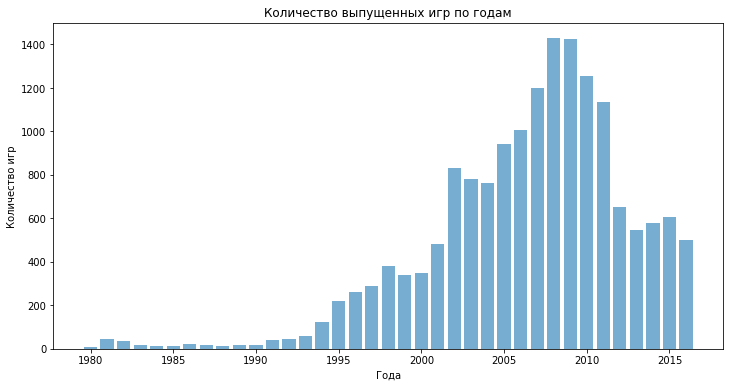

In [ ]:
x = df.sort_values(by="year_of_release")["year_of_release"].dropna().unique()
y = (
    df.sort_values(by="year_of_release")
    .groupby("year_of_release")["name"]
    .count()
    .values
)
plt.bar(x, y, align="center", alpha=0.6)
plt.title("Количество выпущенных игр по годам")
plt.ylabel("Количество игр")
plt.xlabel("Года")
plt.show()

Теперь построим график количества выпущенных игр, взяв за единицу появление игры только на одной из платформ:

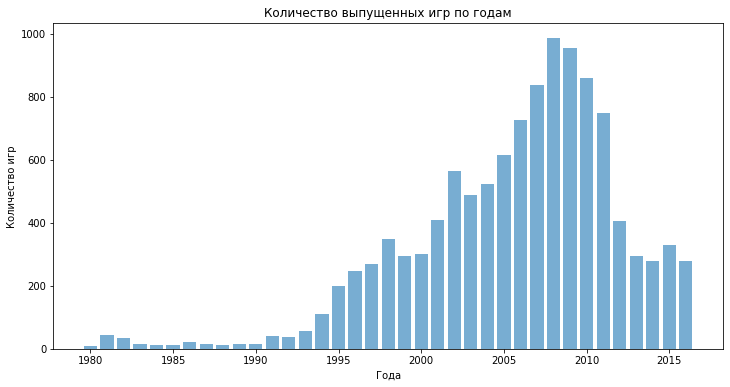

In [ ]:
x = df.drop_duplicates(subset=["name"])
x = x.sort_values(by="year_of_release")["year_of_release"].dropna().unique()
y = (
    df.drop_duplicates(subset=["name"])
    .sort_values(by="year_of_release")
    .groupby("year_of_release")["name"]
    .count()
    .values
)
plt.bar(x, y, align="center", alpha=0.6)
plt.title("Количество выпущенных игр по годам")
plt.ylabel("Количество игр")
plt.xlabel("Года")
plt.show()

Графики, в целом схожи. Время начала и конца трендов совпадают.

Начальному росту в выпуске игр способствовало развитие игровой индустрии, совершенствование технологий. Но, после мирового кризиса 2008 года, который отразился и на компаниях и кошельках потребителей, многие разработчики игр оставались в глубоких долгах, часть обанкротилась.
Например, Electronic Arts пережила кризис так «успешно», что ещё в 2012 году убытки составляли 286 млн. дол., а первую прибыль посчитали только в 2014 — 490 млн. дол. А ведь EA была самым крупным издателем в мире. 

Приложу еще одну версию спада выпуска игр на графике после 2009: возможно, что в имеющихся данных недостает какой-то информации, скажем из области мобильных видеоигр или онлайн-сервисов.

### Самые популярные платформы за все время

Давайте выберем топ 10 платформ с наивысшими продажами:

In [ ]:
top_platform_list = (
    df.groupby("platform")["total_sales"].sum().sort_values(ascending=False).head(10)
)
top_platform_list

platform
PS2     1255.770020
X360     971.419983
PS3      939.640015
Wii      907.510010
DS       806.119995
PS       730.859985
GBA      317.850006
PS4      314.140015
PSP      294.049988
PC       259.519989
Name: total_sales, dtype: float32

Здесь показаны самые популярные игровые приставки с точки зрения общего количества проданных игр. Первое место занимает компания Sony, которая продала более 1,2 миллиарда игр за все время для своей чрезвычайно популярной консоли PlayStation 2 по состоянию на 2016 год. Xbox 360 от Microsoft занимает второе место, но Nintendo также показала хорошие результаты, две ее консоли вошли в пятерку лучших.

Сохраним топ платформ в список:

In [ ]:
top_platform_list = top_platform_list.index.tolist()
top_platform_list

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']

Построим распределение продаж по годам:

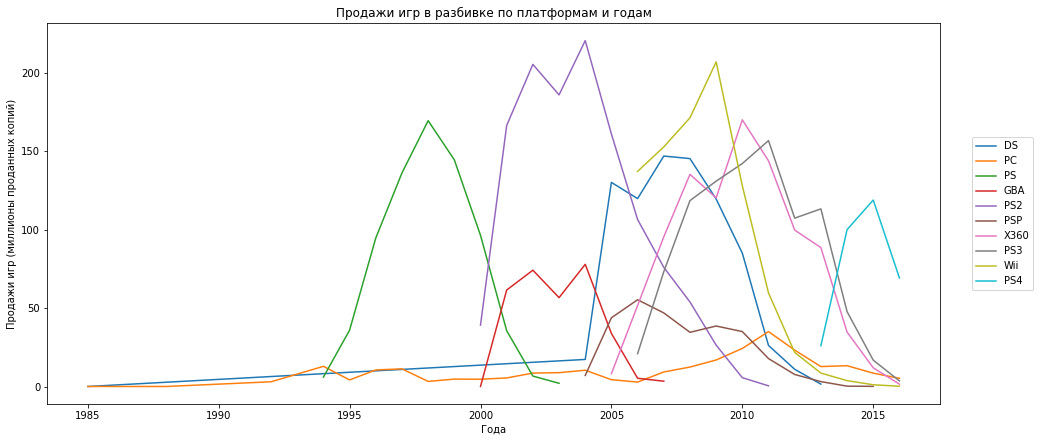

In [ ]:
x = (
    df.query("platform in @top_platform_list")
    .groupby(["year_of_release", "platform"], as_index=False)["total_sales"]
    .sum()
)
fig, ax = plt.subplots(figsize=(16, 7))
sns.lineplot(x="year_of_release", y="total_sales", data=x, hue="platform")
plt.legend(loc="center", bbox_to_anchor=(1.07, 0.5))
plt.title("Продажи игр в разбивке по платформам и годам")
plt.ylabel("Продажи игр (миллионы проданных копий)")
plt.xlabel("Года")
plt.show()

По графику заметно, что среднее время актуальности платформ - 5-7 лет. При появлении новых платформ, старые начинают терять продажи игр.

Отдельно стоит заметить, что PC - платформа, возраст которой сильно не влияет на её популярность или на её продажи. Она стабильно занимает определенную долю рынка в последние годы датасета. И вряд ли покажет спад актуальности в прогнозируемом периоде.

### Определение актуального периода для исследования

Актуальный период исследования завязан на актуальности самих платформ. Поэтому для точности, рассчитаем последнее. За окончание актуальности платформы возьмем снижение годовых общих продаж по платформе ниже среднего по этой платформе и прохождение этой платформой середины своей жизни.

Проверим для начала распредение значений возраста платформ:

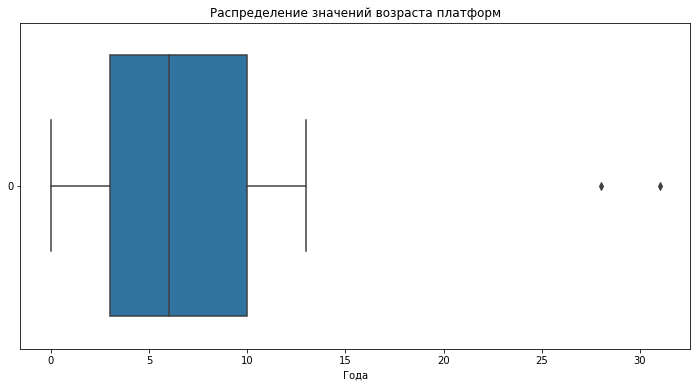

In [ ]:
x = (
    df.groupby("platform")["year_of_release"].max()
    - df.groupby("platform")["year_of_release"].min()
)
sns.boxplot(data=x, orient="h")
plt.title("Распределение значений возраста платформ")
plt.xlabel("Года")
plt.show()

Взлянем на эти значения:

In [ ]:
x.sort_values()

platform
GG       0.0
PCFX     0.0
TG16     0.0
3DO      1.0
SCD      1.0
WS       2.0
NG       3.0
XOne     3.0
PS4      3.0
GEN      4.0
WiiU     4.0
PSV      5.0
3DS      5.0
SAT      5.0
N64      6.0
GC       6.0
GBA      7.0
XB       8.0
SNES     9.0
2600     9.0
PS       9.0
PS3     10.0
Wii     10.0
DC      10.0
PS2     11.0
NES     11.0
X360    11.0
PSP     11.0
GB      13.0
DS      28.0
PC      31.0
Name: year_of_release, dtype: float64

И рассчитаем среднюю продолжительность жизни платформы по данным, исключив из расчета экстремальные значения:

In [ ]:
x[
    (x < 15) & (x >= 2)
].mean()  # отсечем  платформы которые живут меньше двух лет. По таким платформам сложно что-то спрогнозировать.

7.291666666666667

Средний цикл жизни платформы - около 7 лет.

Сохраним список платформ по которым делали расчет:

In [ ]:
standard_platforms = x[(x < 15) & (x >= 2)].index.tolist()

Создадим столбец который показывает сколько на момент года релиза игры, существовала платформа лет:

In [ ]:
df["year_birth_platform"] = df["platform"].map(
    df.groupby("platform")["year_of_release"].min()
)  # создаем столбец года рождения платформы
df["age_of_platform"] = df["year_of_release"] - df["platform"].map(
    df.groupby("platform")["year_of_release"].min()
)  # высчитываем для каждого года таблицы возраст платформы
df.loc[
    df["year_of_release"].notna(),
    ["name", "platform", "year_birth_platform", "age_of_platform"],
].sample(5)

,name,platform,year_birth_platform,age_of_platform
5274,worms: open warfare 2,DS,1985.0,22.0
6170,wild arms 5,PS2,2000.0,6.0
9879,onimusha: blade warriors,PS2,2000.0,3.0
13001,animal planet: vet collection,DS,1985.0,25.0
15359,"renai banchou: inochi meishi, koiseyo otome! l...",PSP,2004.0,6.0


Теперь рассчитаем средний возраст платформы, когда впервые наблюдался спад продаж (общие продажи ниже среднего по платформе):

In [ ]:
x = df.query("platform in @standard_platforms")
x = x.groupby(["platform", "year_of_release"], as_index=False).agg(
    {"total_sales": "sum", "year_birth_platform": "last", "age_of_platform": "last"}
)
x.columns = [
    "platform",
    "year_of_release",
    "total_sales_by_year",
    "year_birth_platform",
    "age_of_platform",
]
x["mean_sales_by_platform"] = x["platform"].map(
    x.groupby("platform")["total_sales_by_year"].mean()
)  # создаем столбец средних продаж платформы за все годы существования
x["max_age_platform"] = x["middle_age_platform"] = x["platform"].map(
    x.groupby("platform")["age_of_platform"].max()
)  # создаем столбец который показывает максимальный возраст платформы
x["middle_age_platform"] = (x["max_age_platform"] / 2).apply(
    np.floor
)  # считаем середину жизни платформы.
x[
    "decline_of_platform"
] = True  # создаем столбец который покажет, когда продажи по платформе идут ниже среднего по ней же.
x["decline_of_platform"] = x["decline_of_platform"].where(
    (x["total_sales_by_year"] < x["mean_sales_by_platform"])
    & (x["age_of_platform"] >= x["middle_age_platform"]),
    False,
)  # заполняем False если платформа не достигла среднего своего возраста и не потеряла в продажах
x[x["decline_of_platform"]].groupby("platform")[
    "age_of_platform"
].min().mean()  # высчитываем среднее по году начала спада продаж платформ

5.083333333333333

В среднем спад продаж по платформам наблюдается через 5 лет после её появления на рынке.

Теперь посмотрим, какого возраста достигли платформы в 2016 году:

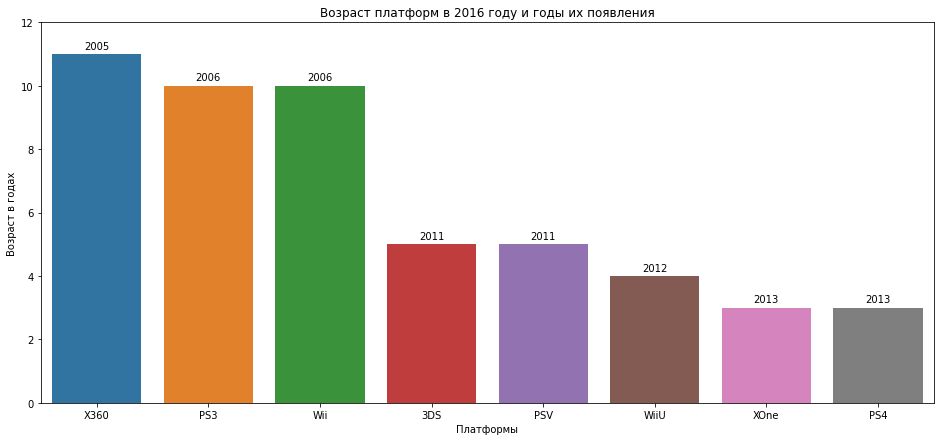

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.set_ylabel("Количество лет существования платформы по имеющимся данным")
sns.barplot(
    x="platform",
    y="age_of_platform",
    data=df.query('year_of_release==2016 and platform!="PC"').sort_values(
        by="year_birth_platform"
    ),
)
plt.ylim(0, 12)
rects = ax.patches
x = df.query('year_of_release==2016 and platform!="PC"').sort_values(
    by="year_birth_platform"
)
x = x.groupby("platform")["year_birth_platform"].last()
labels = x.sort_values().astype(int)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 0.1,
        label,
        ha="center",
        va="bottom",
    )

ax.set_ylabel("Возраст в годах")
ax.set_xlabel("Платформы")
plt.title("Возраст платформ в 2016 году и годы их появления")
plt.show()

Мы видим, что PS4 и XOne самые молодые и, соответственно, набирающие оборот по продажам платформы. 

Поняв когда приблизительно платформа теряет актуальность, можно сократить рассматриваемый период до 4 лет (с 2013 по 2016), так как при увеличении периода захватываются данные слишком устаревших платформ. И при этом отсекаются платформы, которые на момент 2017 года войдут в фазу "устаревания" и соотвественно, будут терять в продажах игр (WiiU входит в зону риска, для 3DS и PSV прогнозируется устаревание). 

In [ ]:
df_actual = df.query("year_of_release>=2013")

### Актуальные лидеры по продажам

Кажется, после 2009 заметен общий спад по продажам игр. Взглянем на общую выручку за все игры по нашим данным:

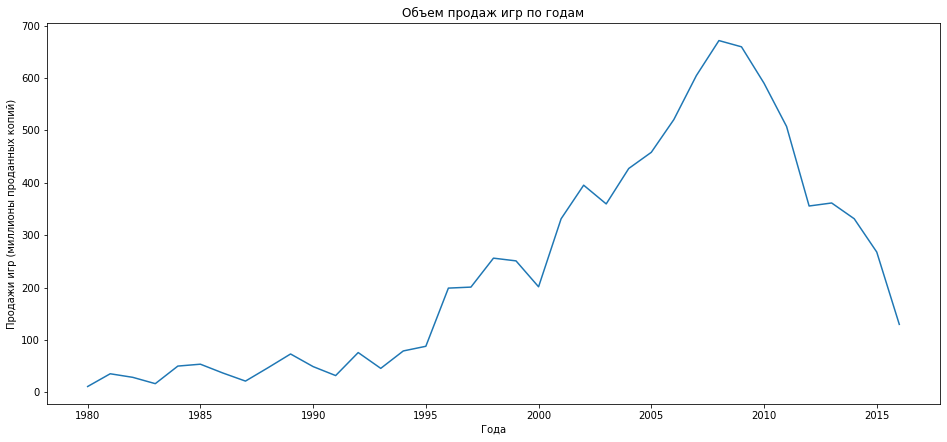

In [ ]:
x = df.groupby(["year_of_release"], as_index=False)["total_sales"].sum()
fig, ax = plt.subplots(figsize=(16, 7))
sns.lineplot(x="year_of_release", y="total_sales", data=x)
plt.title("Объем продаж игр по годам")
plt.xlabel("Года")
plt.ylabel("Продажи игр (миллионы проданных копий)")
plt.show()

Меньше выпущенных игр - меньше продаж игр?
Весьма напрашивающаяся связь. 
Но рассмотрим и другие причины.

Кажется, что в таблице либо не учтены часть игр за последние 8 лет, либо не учтена целая отрасль игр, либо платформа.

Но и есть вероятность, что график вполне достоверно отражает прошлое игровой индустрии.

Если это так, одна из догадок, согласно  [отчету Tinkoff](https://www.tinkoff.ru/invest/research/strategy/2021-videogames/)  - падение продаж связано с ростом популярности смартфонов и мобильных игр, которые не учтены в таблице.

Согласно [другому источнику](https://medium.com/analytics-vidhya/a-data-driven-exploration-of-video-games-sales-and-scores-3c77f1c6573c) - это может иметь несколько объяснений. Некоторые эксперты считают, что это результат нестабильной экономики, когда финансовый кризис 2007-2008 годов заставил потребителей сократить ненужные расходы. Другие винят перенасыщенность игровой индустрии, отсутствие новых свежих игр и консолей для поддержания интереса покупателей. Возможно, также введение цифровых продаж игр через такие платформы, как Steam и Epic Games, внесло большой вклад в снижение количества проданных физических копий.

В любом случае, опираться на абсолютные продажи по платформам, лучше не стоит. Лучше высчитать долю продаж игр для каждой платформы от общих продаж в имеющихся данных, чтобы не оглядываясь общемировой тренд, выявить локальные тренды на нормализованном графике:

In [ ]:
x = df_actual.groupby(["year_of_release", "platform"], as_index=False)[
    "total_sales"
].sum()  # считаем суммарные продажи на каждый год

x["total_sales_in_year"] = x["year_of_release"].map(
    df.groupby(["year_of_release"])["total_sales"].sum()
)  # добавляем столбик суммарных годовых продаж для каждой строчки таблицы
x["sales_share"] = (
    x["total_sales"] / x["total_sales_in_year"]
)  # делим суммарные продажи игры на суммарные продажи всех игр в этом году
x.sample(10)  # выводим

,year_of_release,platform,total_sales,total_sales_in_year,sales_share
25,2015.0,PSP,0.120000,267.980011,0.000448
5,2013.0,PSP,3.140000,361.589996,0.008684
38,2016.0,X360,1.520000,129.940002,0.011698
39,2016.0,XOne,26.150000,129.940002,0.201247
37,2016.0,WiiU,4.600000,129.940002,0.035401
17,2014.0,Wii,3.750000,331.529999,0.011311
6,2013.0,PSV,10.590000,361.589996,0.029287
12,2014.0,PC,13.280001,331.529999,0.040057
14,2014.0,PS4,100.000000,331.529999,0.301632
0,2013.0,3DS,56.570000,361.589996,0.156448


Посмотрим на лидеров по продажам за актуальный период:

In [ ]:
top_platform_list = (
    df_actual.groupby("platform")["total_sales"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_platform_list = top_platform_list.index.tolist()
top_platform_list

['PS4', 'PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP']

И построим график, показывающий занятую ими долю рынка:

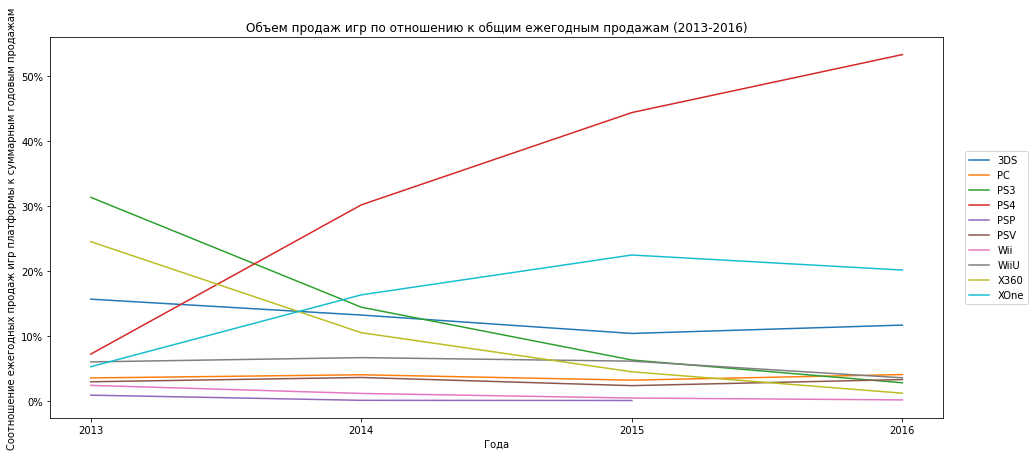

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel("Соотношение ежегодных продаж игр платформы к суммарным годовым продажам")
sns.lineplot(
    x="year_of_release",
    y="sales_share",
    data=x.query("platform in @top_platform_list"),
    hue="platform",
)
plt.title("Объем продаж игр по отношению к общим ежегодным продажам (2013-2016)")
plt.legend(loc="center", bbox_to_anchor=(1.06, 0.5))
ax.xaxis.set_ticks(np.arange(2013, 2017, 1))
plt.xlabel("Года")
plt.show()

Теперь, когда график нормализован, по нему уже можно дать какие-то выводы.

Когда-то популярную PS3 постепенно заменяет PS4, которая растет последние 3 года датасета, как и X Box One, отстающая от лидера в продажах более чем в 2 раза, пришедшая на смену устаревшей Xbox 360.
На третьем месте портативная платформа 3DS, возраст которой в 2016 году был около 5 лет, что говорит о её возможном скором уходе с глобального рынка.
И действительно, в 2017 году выходит Nintendo Switch, которая потихоньку заменяет на рынке 3DS, вплоть до снятия 3DS в 2020 с производства.

Остальные платформы теряют в продажах, либо имеют низкий уровень продаж:

In [ ]:
x.groupby("platform")["total_sales"].sum().sort_values(ascending=True).head(
    6
).index.tolist()

['DS', 'PSP', 'Wii', 'PSV', 'PC', 'WiiU']

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам:

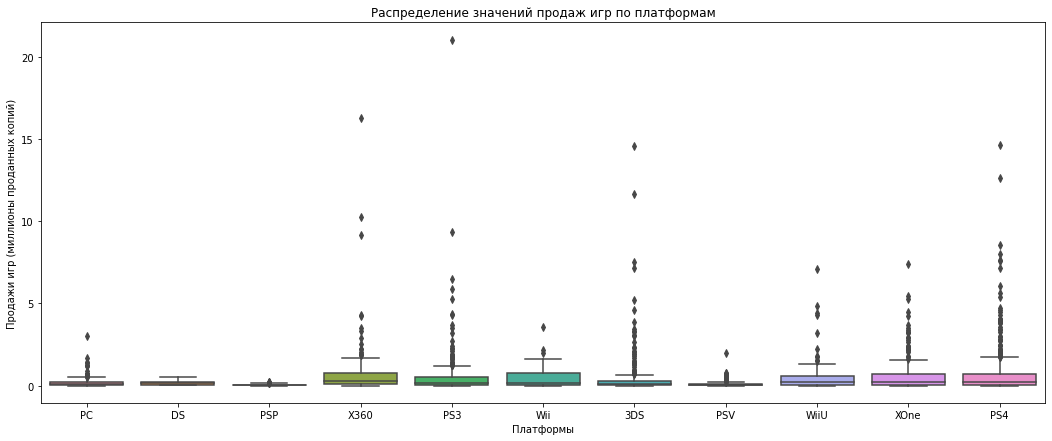

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.boxplot(
    y="total_sales", data=df_actual.sort_values(by="year_birth_platform"), x="platform"
)
plt.ylabel("Продажи игр (миллионы проданных копий)")
plt.title("Распределение значений продаж игр по платформам")
ax.set_xlabel("Платформы")
plt.show()

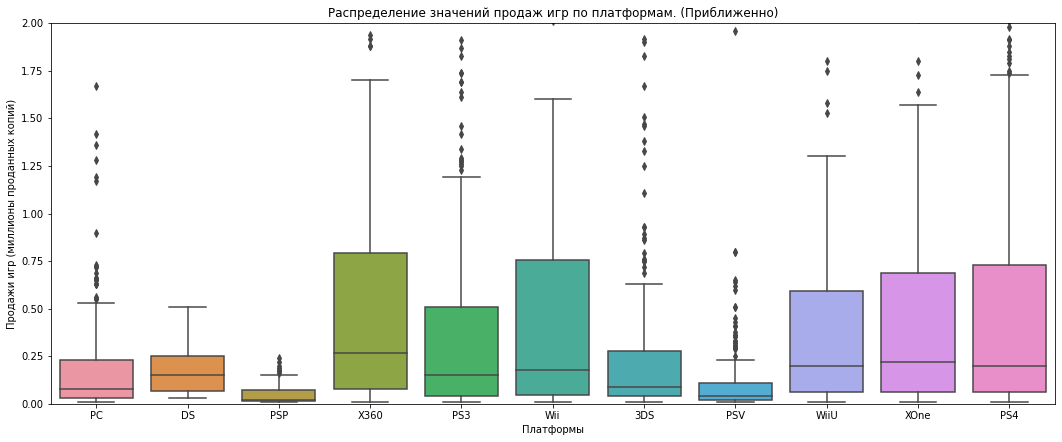

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.boxplot(
    y="total_sales", data=df_actual.sort_values(by="year_birth_platform"), x="platform"
)
plt.ylabel("Продажи игр (миллионы проданных копий)")
plt.title("Распределение значений продаж игр по платформам. (Приближенно)")
ax.set_ylim([0, 2])
ax.set_xlabel("Платформы")
plt.show()

Флагманы потипу X Box 360, PS3 имеют большой разброс в данных в силу длительного срока своей жизни и популярности в прошлом. У 3DS сопоставимый разброс значений с PS4, но  медианные продажи низкие.
3DS - единственная наиболее свежая за актуальный период портативная консоль, на которой вышло тысячи игр, поэтому она имеет такую популярность, и как следствие - большие продажи для некоторых игр.
Игры на X Box One примерно по медиане равны с PS4, но также, как и с WiiU, мало игр с высокими продажами. Для  X Box One это, по-видимому объясняется относительной молодостью платформы и потерянной популярностью вследствии превосходства PS4 по ряду факторов. WiiU же отстает по другим причинам. Консоль была выпущена в очень неудобное время, за год до выпуска PS4 и X Box One. Несмотря на относительно небольшую цену, внутри было очень устаревшее железо и все ждали производительные новые консоли от Sony и Microsoft.

Распределения значений продаж игр в большинстве случаев носят похожий на экспонециальный характер.

Выберем самую молодую и большую по сумме продаж игр последних лет датасета платформу PS4 для анализа.

### Влияние внутри одной популярной платформы отзывов пользователей и критиков на продажи

Построим диаграмму рассеивания и посчитаем корреляцию между отзывами и продажами:

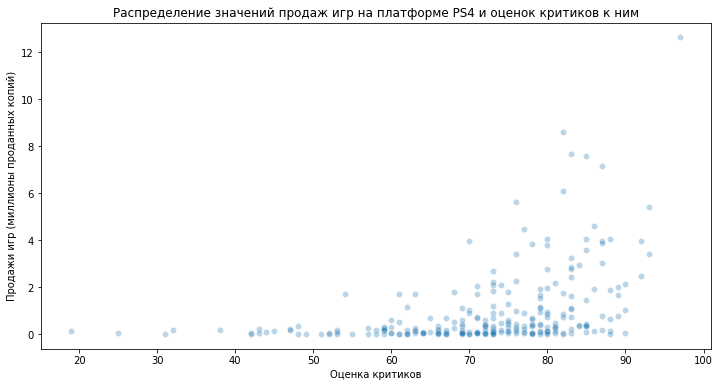

In [ ]:
sns.scatterplot(
    x="critic_score",
    y="total_sales",
    data=df_actual.query('platform=="PS4"'),
    alpha=0.3,
)
plt.ylabel("Продажи игр (миллионы проданных копий)")
plt.xlabel("Оценка критиков")
plt.title("Распределение значений продаж игр на платформе PS4 и оценок критиков к ним")
plt.show()

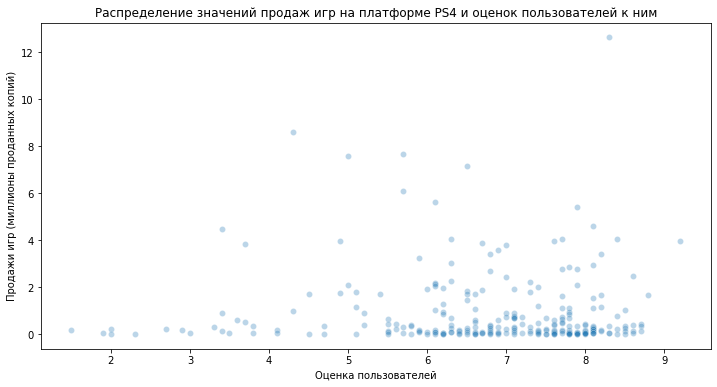

In [ ]:
sns.scatterplot(
    x="user_score", y="total_sales", data=df_actual.query('platform=="PS4"'), alpha=0.3
)
plt.ylabel("Продажи игр (миллионы проданных копий)")
plt.title(
    "Распределение значений продаж игр на платформе PS4 и оценок пользователей к ним"
)
plt.xlabel("Оценка пользователей")
plt.show()

In [ ]:
x = df_actual.query('platform=="PS4"')
x["total_sales"].corr(x["user_score"])

-0.031957105603966966

In [ ]:
x["total_sales"].corr(x["critic_score"])

0.4065679010283494

По графикам заметно, что высокие оценки критиков дают больший разброс в показателях продаж игры.
Коэффициент Пирсона и графики показывают отсутствие линейной связи пользовательской оценки с продажами.

Оценка критиков более важна, вероятно, по тому, что, во-первых, у обычного человека, нет возможности проверять все игры перед покупкой, на это банально не хватит никакого времени. А значит, игроки, хотя бы частично, полагаются на оценку критиков, перед покупкой. Во-вторых,игровые критики чаще всего получают копию игры до релиза, а значит они могут сформировать мнение о ней раньше остальных. И их оценка напрямую влияет на будущее этой игры, или даже целой франшизы. Ведь, если критики занизят игре баллы, высока вероятность, что и игроки пройдут мимо неё. А значит команда разработчиков, в лучшем случае - получит меньше денег на следующей проект, а в худшем - вовсе будет расформирована. И наоборот, при неоправданно завышенных оценках - страдают уже игроки, которые потратят свои кровные деньги на некачественный продукт.

Оценка критика весомей обычного пользователя тем, что критик - имеет авторитет среди пользователей, который зависит опять же, от объективности оценки и осмысленного обзора игры.


Посчитаем коэффициент Пирсона для этих же показателей но уже по общим данным:

In [ ]:
x = df_actual  # берем срез с 2013, года начала продаж PS4
x["total_sales"].corr(x["user_score"])

-0.002845243217376373

In [ ]:
x["total_sales"].corr(x["critic_score"])

0.3132215743530609

Можно увидеть, что связь между оценками игры и продажами слабее в общем понимании, нежели если рассматривать только игры для PS4. Коэффициент Пирсона для пользовательской оценки и продаж на основании общих данных показывает отсутствие связи между двумя показателями.

Посчитаем коэффициенты Пирсона для каждой отдельной платформы в актуальном периоде:

In [ ]:
platforms = df_actual["platform"].unique().tolist()
df_temp = pd.DataFrame(data=[], index=[])
crit_score = []
user_score = []
n_user_score = []
n_crit_score = []
ind = []  # список индексов будущий
for i in platforms:
    x = df_actual[
        df_actual["platform"] == i
    ]  # за период расчета взял большую область, так как слишком мало экземпляров попадает в 4 года для каждой платформы. Соотвественно - большая погрешность при вычислениях
    if (
        len(x["critic_score"].notna()) > 20 and len(x["user_score"].notna()) > 20
    ):  # считаем, чтоб в выборке было больше 20 значений, иначе велика будет ошибка выборки
        crit_score.append(x["total_sales"].corr(x["critic_score"]))
        user_score.append(x["total_sales"].corr(x["user_score"]))
        # n_crit_score.append(len(x[x["user_score"].notnull()]))
        # n_user_score.append(len(x[x["critic_score"].notnull()]))
        ind.append(i)

df_temp["platform"] = ind
df_temp = df_temp.set_index("platform")
df_temp["crit_score_cor"] = crit_score
df_temp["user_score_cor"] = user_score
# df_temp["n_crit_score"] = n_crit_score
# df_temp["n_user_score"] = n_user_score

df_temp.round(2).sort_values(by="crit_score_cor", ascending=False).dropna()

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning:

Degrees of freedom <= 0 for slice



,crit_score_cor,user_score_cor
platform,,
XOne,0.42,-0.07
PS4,0.41,-0.03
WiiU,0.38,0.42
3DS,0.36,0.24
X360,0.35,-0.01
PS3,0.33,0.00
PSV,0.25,0.00
PC,0.20,-0.09


Из полученных значений коэффициента Пирсона можно предположить, что наиболее влиятельной оценка критиков оказывается для игр, изданных на консолях X Box One и PS4.
Заметно, что чем популярней и актуальней платформа, тем, вероятно, больше связь продаж игр на ней с оценкой игр критиков.
Возможно, это связано с тем, что выбор игр на менее популярных платформах скромнее, и, соотвественно, принятие решение пользователя о покупке в ограниченном наборе игр делается быстрее и не нуждается в дополнительных процессах анализа.

Линейная связь продаж с пользовательской оценкой на всех платформах слабая, за исключением платформы WiiU.


### Самые прибыльные жанры

Посмотрим на общее распределение игр по жанрам в разрезе общих продаж:

In [ ]:
(df_actual.groupby("genre")["name"].count() / df_actual["name"].count()).sort_values(
    ascending=False
)

genre
Action          0.343330
Role-Playing    0.130707
Adventure       0.109669
Sports          0.095792
Shooter         0.083706
Misc            0.069382
Racing          0.038048
Fighting        0.035810
Platform        0.033124
Simulation      0.027753
Strategy        0.025067
Puzzle          0.007610
Name: name, dtype: float64

Игры в стиле Action самые распостраненные по количеству. Далее идут ролевые игры. Тройку распостраненных игр занимает жанр приключений.

Но количество не значит качество. Чтобы понять какой жанр прибыльней, нужно найти среднее по продажам игр каждого жанра.

Выделим топ 4 жанра игр по средней продаже за актуальный период:

In [ ]:
lst = (
    df_actual.groupby("genre")["total_sales"]
    .mean()
    .sort_values(ascending=False)
    .head(4)
    .index.tolist()
)
lst

['Shooter', 'Sports', 'Platform', 'Role-Playing']

Если смотреть по средним продажам, то игры-стрелялки оказываются в топ самых прибыльных, за ними идут платформеры, далее - спортивные и ролевые игры.

Стоит посмотреть на изменение средних продаж в динамике:

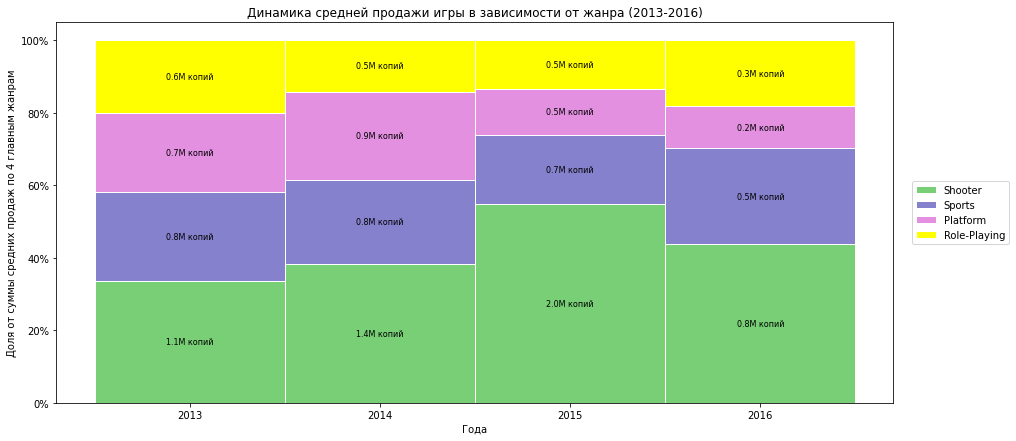

In [ ]:
x = df_actual.query("genre in @lst").pivot_table(
    index="genre", columns="year_of_release", values="total_sales", aggfunc="mean"
)

barWidth = 1
fig, ax = plt.subplots(figsize=(15, 7))
bars1 = x.loc[lst[0], :] / x.agg("sum", axis=0)
bars2 = x.loc[lst[1], :] / x.agg("sum", axis=0)
bars3 = x.loc[lst[2], :] / x.agg("sum", axis=0)
bars4 = x.loc[lst[3], :] / x.agg("sum", axis=0)
bars = np.add(bars1, bars2).tolist()
plt.bar(
    x.columns,
    bars1,
    color="#78cf76",
    edgecolor="white",
    width=barWidth,
    label=lst[0],
)
plt.bar(
    x.columns,
    bars2,
    bottom=np.array(bars1),
    color="#8681cd",
    edgecolor="white",
    width=barWidth,
    label=lst[1],
)
plt.bar(
    x.columns,
    bars3,
    bottom=np.array(bars2) + np.array(bars1),
    color="#e290df",
    edgecolor="white",
    width=barWidth,
    label=lst[2],
)
plt.bar(
    x.columns,
    bars4,
    bottom=np.array(bars3) + np.array(bars2) + np.array(bars1),
    color="yellow",
    edgecolor="white",
    width=barWidth,
    label=lst[3],
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.legend(loc="center", bbox_to_anchor=(1.08, 0.5))
ax.set_xlabel("Года")
ax.set_ylabel("Доля от суммы средних продаж по 4 главным жанрам")
plt.title("Динамика средней продажи игры в зависимости от жанра (2013-2016)")

ax.xaxis.set_ticks(np.arange(2013, 2017, 1))
for i, rect in enumerate(ax.patches):
    height = rect.get_height()
    width = rect.get_width()
    X = rect.get_x()
    y = rect.get_y()
    t = i % x.shape[1]
    label_text = f'{height*x.iloc[:,t].agg("sum", axis=0):.1f}М копий'
    label_x = X + width / 2
    label_y = y + height / 2
    if height > 0.001:
        ax.text(label_x, label_y, label_text, ha="center", va="center", fontsize=8)
plt.show()

Заметно, что жанры Sports и Shooter действительно имееют хорошую среднюю продаж с трендом на увеличение прибыльности относительно других жанров. Игры-платформеры же, наоборот, сильно сдают позиции последние два года датасета. Ролевые игры практически не меняются по прибыльности в динамике.

Давайте кроме прибыльности жанров, посмотрим, в какие жанры вообще предпочитают играть люди:

In [ ]:
df_actual.groupby("genre")["total_sales"].sum().sort_values(ascending=False).head(4)

genre
Action          322.220001
Shooter         232.979996
Sports          150.649994
Role-Playing    145.889999
Name: total_sales, dtype: float32

Action лидирует по популярности в общих продажах.

**Вывод**



В процессе исследования было установлено, что основная масса кассовых игр выпускаются на платформах, имеющих цикличность в 7-10 лет. Причем, в среднем на пятый год существования платформа начинает устаревать. 
На рынке игровых платформ в актуальном периоде имеются 3 основых игрока: Nintendo, Sony, Microsoft. Очередность их популярности менялась в течение большого периода развития игровой индустрии и, в основном, привязана к появлению новых платформ от этих компаний.
Платформы отличаются: есть портативные модели, есть стационарные.

Была установлена связь оценкок игр со стороны критиков и продаж. 
Также замечено, что некоторые жанры пользуются большим спросом в общей массе чем остальные.

Из жанров заслуживающих внимание для продаж подходят шутеры и спортивные игры. И уже во-вторую очередь стоит смотреть на платформенные и ролевые игры.

Судя по полученным данным, в последние годы игровая индустрия переживает кризис количества игр и их продаж.

 

## Портрет пользователя каждого региона

Чтобы составить портрет пользователя каждого региона мы будем пользоваться данными о продажах игр в этих регионах.

Выделим самые популярные платформы:

In [ ]:
df_actual.groupby("platform")["na_sales"].sum().sort_values(ascending=False).head(
    5
).index.tolist()

['PS4', 'XOne', 'X360', 'PS3', '3DS']

In [ ]:
df_actual.groupby("platform")["eu_sales"].sum().sort_values(ascending=False).head(
    5
).index.tolist()

['PS4', 'PS3', 'XOne', 'X360', '3DS']

In [ ]:
df_actual.groupby("platform")["jp_sales"].sum().sort_values(ascending=False).head(
    5
).index.tolist()

['3DS', 'PS3', 'PSV', 'PS4', 'WiiU']

In [ ]:
EU = df_actual.pivot_table("eu_sales", columns="platform", aggfunc="sum").T
EU = EU.sort_values(by="eu_sales", ascending=False).iloc[0:5]
EU_platforms = EU.index

JP = df_actual.pivot_table("jp_sales", columns="platform", aggfunc="sum").T
JP = JP.sort_values(by="jp_sales", ascending=False).iloc[0:5]
JP_platforms = JP.index

NA = df_actual.pivot_table("na_sales", columns="platform", aggfunc="sum").T
NA = NA.sort_values(by="na_sales", ascending=False).iloc[0:5]
NA_platforms = NA.index

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y=NA["na_sales"],
        x=NA_platforms,
        name="North America",
        marker={"color": NA["na_sales"], "colorscale": "tealgrn"},
    )
)
fig.add_trace(
    go.Bar(
        y=EU["eu_sales"],
        x=EU_platforms,
        name="Europe",
        marker={"color": EU["eu_sales"], "colorscale": "tealgrn"},
        visible=False,
    )
)
fig.add_trace(
    go.Bar(
        y=JP["jp_sales"],
        x=JP_platforms,
        name="Japan",
        marker={"color": JP["jp_sales"], "colorscale": "tealgrn"},
        visible=False,
    )
)

buttons = []
regions = ["Северная Америка", "Европа", "Япония"]

for i, region in enumerate(regions):
    buttons.append(
        dict(
            label=region,
            method="update",
            args=[
                {"visible": [False] * i + [True] + [False] * (3 - i + 1)},
                {"title": f"Top 5 платформ по продажам игр. {region}"},
            ],
        )
    )

fig.update_layout(
    yaxis_title="Продажи игр (миллионы проданных копий)",
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=1.17,
            y=1.2,
            buttons=buttons,
        )
    ],
)

fig.update_layout(title_text="Top 5 платформ по региону", xaxis_domain=[0.05, 1.0])
fig.show()

На первом месте в Cеверной Америке по продажам игр японская платформа PS4. Второе и третье место занимают 2 версии американской X Box. 
Чтобы понять такую расстановку сил, надо погрузиться немного в историю.
До начала продаж приставок X Box One и PS4 в конце 2013 Sony, бывший лидер рынка, униженно плелась в хвосте, уступив место и Microsoft, и Nintendo. Консоль X360 оставалась лидером в продажах прежде всего из-за своего технологического превосходства. Вероятно поэтому у нее 3е место в Северо-американском топе. На момент 2013 года PS4 учла огрехи прошлой версии и перезентовалась как чисто игровая консоль, в то время как Microsoft перед запуском X Box One сделал множество промахов и тем самым не только потерял инициативу на старте, но и в целом выпустил консоль более слабой, нежели PS4.
X Box занимает более высокие позиции в Северной Америке, чем в Европе.
Рискну предположить, это из-за того, что платформа разработана американской компанией, и её рекламная политика намного больше заточена на Северную Америку.

По тем же причинам, вероятно, в японских продажах топ 5 занимают платформы разработанные японскими компаниями - Nintendo и Sony. На отсутствие иностранных платформ в топе мог оказать тот факт, что иностранные компании мало заинтересованы в локализации своих продуктов на этом рынке.
К тому же, 2 из 5 топ платформ на японском рынке за рассматриваемый период - портативные.
Это связываю с «аркадным» прошлым ведущих платформодержателей в стране. 

Смотря топ 5 европейский платформ по продажам игр, мы не увидим среди них платформы европейского производства, так как они попросту не существуют. Японские и американские компании, видимо, давно заняли мировой рынок и создать новую платформу Европе самой становится проблематично.

____________________________

Определим самые популярные жанры для пользователей в разрезе местоположения:

In [ ]:
df_actual.groupby("genre")["na_sales"].sum().sort_values(ascending=False).head(
    5
).index.tolist()

['Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc']

In [ ]:
df_actual.groupby("genre")["eu_sales"].sum().sort_values(ascending=False).head(
    5
).index.tolist()

['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing']

In [ ]:
df_actual.groupby("genre")["jp_sales"].sum().sort_values(ascending=False).head(
    5
).index.tolist()

['Role-Playing', 'Action', 'Misc', 'Fighting', 'Shooter']

Японский рынок видео игр изначально завязан на Role-Playing играх. RPG в Японии был и остаётся важнейшим жанром, Поэтому он лидирует в топе популярности жанров последних лет датасета. К тому же, японские разработчики игр создали даже свой жанр RPG - JRPG.

Американский и европейский рынок почти идентичен в своем топе жанров для игр. Это можно объяснить схожестью социума этих двух рынков по ряду признаков.

_________________________

Изучим, влияет ли рейтинг ESRB на продажи в отдельном регионе:

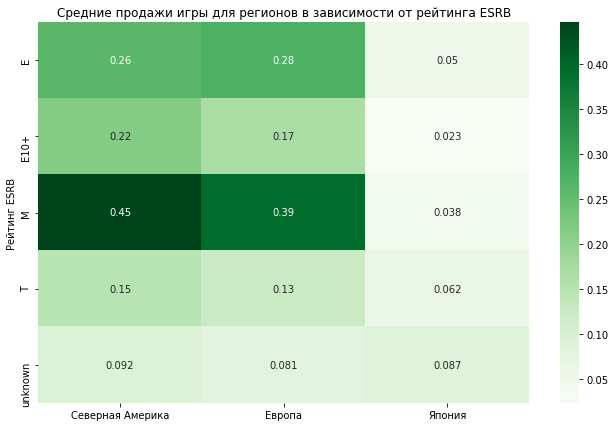

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(
    df_actual[(df_actual["rating"].notnull()) & (df_actual["rating"] != "EC")]
    .groupby("rating")[["na_sales", "eu_sales", "jp_sales"]]
    .mean(),
    annot=True,
    fmt=".2g",
    cmap="Greens",
    ax=ax,
)
plt.title("Средние продажи игры для регионов в зависимости от рейтинга ESRB")
ax.set_xticklabels(["Северная Америка", "Европа", "Япония"])
plt.ylabel("Рейтинг ESRB")
plt.show()

Игры с маркировкой «EC» можно не брать в расчет: их слишком мало, чтобы делать на основе наших расчетов какие-либо выводы.


Если рассматривать только североамериканский и европейский рынок, то, заметно, что у игр с маркировкой «M» («Mature») — «Для взрослых» довольно высокие средние продажи. Вероятно, такие игры пользуются большим спросом и ориентированы на основную возрастную страту потребителей.
Популярность игр с маркировкой «M», скорей всего, обуславливается наличием сцен насилия в этих играх. А наблюдая насилие на экране, мозг своего рода «спускает пар».
Игры без рейтинга не приносят больших продаж в этих регионах. Это связано со [спецификой выпуска игр](#esrb_nan) в Северной Америке,
которую наследует и Европа. 

Ситуация-перевертыш в Японии. Там игры без рейтинга ESRB показывают большие продажи и, кажется, у японских геймеров большей популярностью пользуются игры с маркировкой «T» - для тинейджеров. 
Но, стоит помнить, что у Японии есть собственная рейтинговая организация, которая может выставлять собственные рейтинги, отличные от ESRB. Поэтому наши выводы относительно связи маркировки ESRB с продажами игр в Японии могут быть ошибочными.

**Вывод**



Путем анализа популярных платформ, жанров и игр с рейтингом ESRB удалось понять, что Северо-Американский рынок очень схож по аудитории с рынком Европы. Для них топ 5 платформ, жанров игр и влияние рейтинга ESRB практически идентичны с учетом мелких перестановок позиций.

Японская аудитория же отлична от них. Аутентична в своих предпочтениях.


## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Эта гипотеза о равенстве средних двух генеральных совокупностей, поэтому мы будем использовать метод st.stats.ttest_ind().

Нулевая гипотеза H₀ всегда формулируется так, чтобы использовать знак равенства. В данном случае,  нулевая гипотеза будет означать равенство средних пользовательских рейтингов платформ Xbox One и PC. 
Альтернативная гипотеза будет состоять в том, что средние пользовательские рейтинги Xbox One и PC не равны.  Это утверждение, которое принимается верным, если отбрасывается нулевая гипотеза.

Для начала посмотрим распределение выборок.

X Box One появилась позже PC, в 2013 году, поэтому оценки пользователей мы будем сравнивать начиная c 2013 года для более точного анализа:

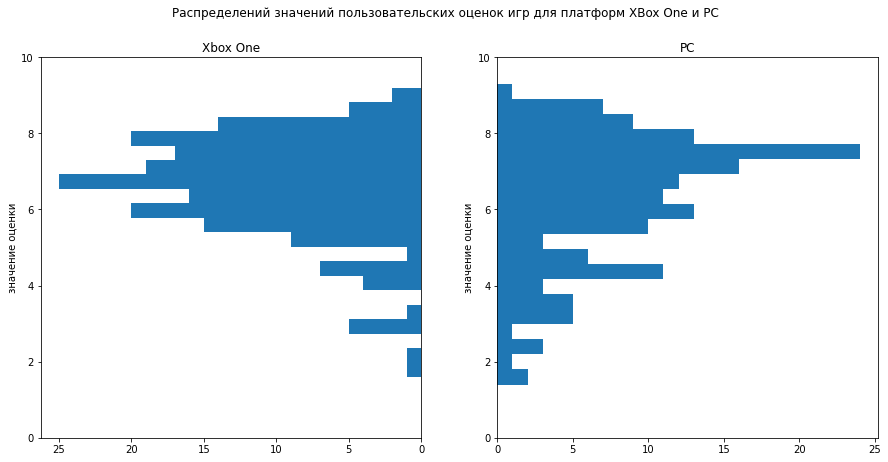

Количество игр с пользовательской оценкой на Xbox One в выборке: 182
Количество игр с пользовательской оценкой на PC в выборке : 156


In [ ]:
x = df_actual[df_actual["user_score"].notnull()]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle(
    "Распределений значений пользовательских оценок игр для платформ XBox One и PC"
)
ax1.set_ylabel("значение оценки")
ax2.set_ylabel("значение оценки")
ax1.set_ylim([0, 10])
ax2.set_ylim([0, 10])
ax1.set_title("Xbox One")
ax2.set_title("PC")
ax1.invert_xaxis()
y = x.loc[x["platform"] == "XOne", "user_score"]

ax1.hist(y, orientation="horizontal", bins=20)
y = x.loc[x["platform"] == "PC", "user_score"]
ax2.hist(y, orientation="horizontal", bins=20)
plt.show()

print(
    "Количество игр с пользовательской оценкой на Xbox One в выборке:",
    x.loc[x["platform"] == "XOne", "user_score"].count(),
)
print(
    "Количество игр с пользовательской оценкой на PC в выборке :",
    x.loc[x["platform"] == "PC", "user_score"].count(),
)

С виду, средние выборок схожи. Размеры выборок же отличаются, поэтому аргументу `equal_var` зададим значение False.

In [ ]:
x = df_actual[df_actual["user_score"].notnull()]
s1 = x.loc[x["platform"] == "XOne", "user_score"]
s2 = x.loc[x["platform"] == "PC", "user_score"]

results = scipy.stats.ttest_ind(s1, s2, equal_var=False)

print(results.pvalue)

0.17156748955612117


И сравним визуально доверительные интервалы двух выборок:

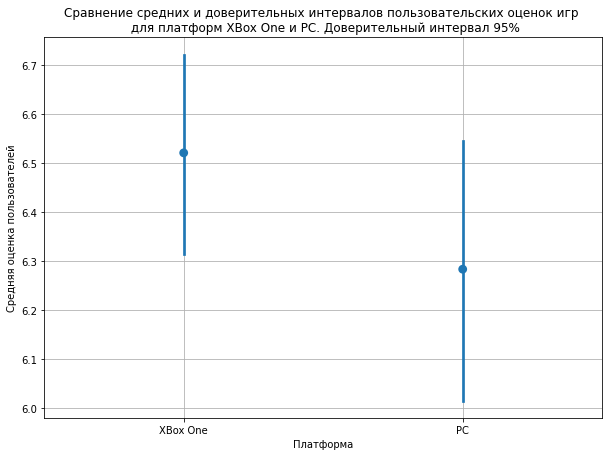

In [ ]:
x = df_actual[
    (df_actual["user_score"].notnull())
    & ((df_actual["platform"] == "XOne") | (df_actual["platform"] == "PC"))
].copy()
fig, ax = plt.subplots(figsize=(10, 7))
sns.pointplot(
    x="platform",
    y="user_score",
    data=x,
    dodge=True,
    join=False,
    ci=95,
)
plt.ylabel("Средняя оценка пользователей")
plt.xlabel("Платформа")
plt.grid()
plt.title(
    "Сравнение средних и доверительных интервалов пользовательских оценок игр \n для платформ XBox One и PC. Доверительный интервал 95%"
)
ax.set_xticklabels(["XBox One", "PC"])

plt.show()

Мы видим что доверительные интервалы (95%) пересекаются, и средняя первой выборки входит в доверительный интервал другой.

Руководствуясь принципом описаном на https://www.statmethods.ru/stati/vybor-urovnya-znachimosti-pri-proverke-statisticheskikh-gipotez/
и взяв в качестве критического уровня статистической значимости уровень в 5%, наша гипотеза о равенстве средних пользовательских рейтингов игр на Xbox One и PC не может быть отвергнута. Найденное значение p-value говорит о том, что вероятность получить такое или большее различие выше порогового уровня критерия. При условии, что нулевая гипотеза верна, это слишком большая вероятность, чтобы делать вывод о различии средних пользовательских рейтингов игр на Xbox One и PC.


Отличия в средних оценках игр, вероятно, обусловлено тем, что многие одинаковые игры выпускаются на обеих площадках и не имеют различий по графике. Количество игр-эксклюзивов тоже примерно равно по платформам.

### Средние пользовательские рейтинги жанров Action и Sports разные.

Эта гипотеза о равенстве средних двух генеральных совокупностей, поэтому мы будем использовать метод st.stats.ttest_ind().

Нулевая гипотеза H₀ всегда формулируется так, чтобы использовать знак равенства. В данном случае,  нулевая гипотеза будет означать равенство средних пользовательских рейтингов жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования»). 
Альтернативная гипотеза будет состоять в том, что средние пользовательские рейтинги жанров Action и Sports не равны.  Это утверждение, которое принимается верным, если отбрасывается нулевая гипотеза.

Прежде всего, надо понять за какой период нужно делать вывод. 
Если брать весь период, то теряется актуальность, если брать более акутальный период - уменьшается выборка и, соответственно, точность оценки гипотезы.
Построим графики, которые высчитывают p-value и количество данных для выборок в зависимости от выбранного периода. Это даст понимание как выбор периода данных влияет на проверку гипотезы.

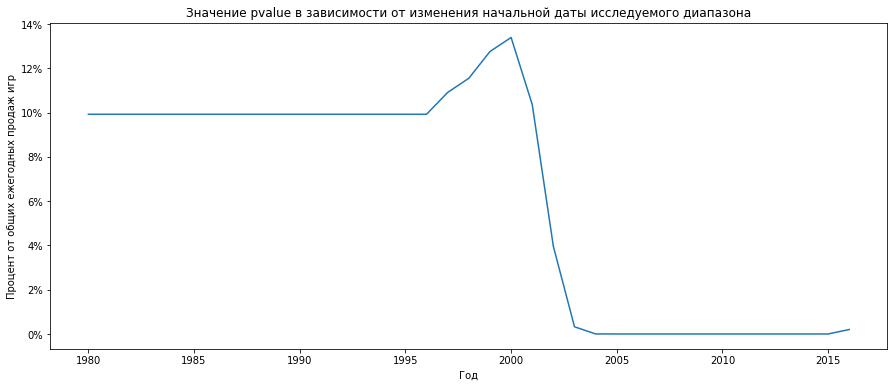

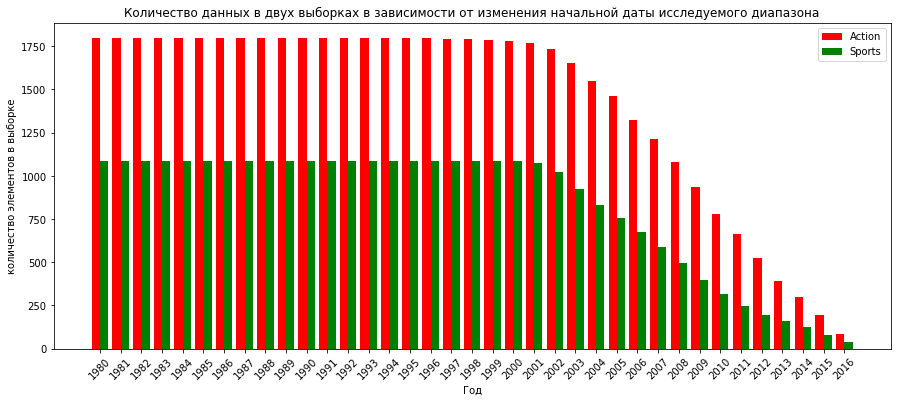

In [ ]:
data = []
n1 = []
n2 = []
for i in range(1980, 2017):
    x = df[(df["year_of_release"] >= i) & (df["user_score"].notnull())]
    s1 = x.loc[x["genre"] == "Action", "user_score"]
    s2 = x.loc[x["genre"] == "Sports", "user_score"]
    results = scipy.stats.ttest_ind(s1, s2, equal_var=False)
    data.append(results.pvalue)
    n1.append(len(x.loc[x["genre"] == "Action", "user_score"]))
    n2.append(len(x.loc[x["genre"] == "Sports", "user_score"]))


fig, ax = plt.subplots(figsize=(15, 6))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel("Процент от общих ежегодных продаж игр")
ax.set_xlabel("Год")
sns.lineplot(x=range(1980, 2017), y=data)
# plt.ylim(0.1,0.4)
# plt.legend(loc="upper left")
plt.title(
    "Значение pvalue в зависимости от изменения начальной даты исследуемого диапазона"
)
plt.show()
fig, ax = plt.subplots(figsize=(15, 6))
X = range(1980, 2017)
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, n1, 0.4, label="Action", color="red")
plt.bar(X_axis + 0.2, n2, 0.4, label="Sports", color="green")
plt.xticks(X_axis, X)
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.title(
    "Количество данных в двух выборках в зависимости от изменения начальной даты исследуемого диапазона"
)
plt.ylabel("количество элементов в выборке")
plt.legend()
plt.show()

Заметно, что полученное значение p-value говорит о том, что вероятность получить такое или большее различие с играми до 2000 года очень велико.
После 2000г все меняется, и p-value резко опускается. Если брать за рассматриваемый период последние 13 лет, то на основании низкого значения pvalue мы можем отвергнуть нулевую гипотезу.

Выбор рассматриваемого периода радикально влияет на решение о принятии нулевой гипотезы. 
Но, полагаю, что актуальность данных важнее. Поэтому будем проверять гипотезу на основании актуального периода:

In [ ]:
x = df_actual[
    (df_actual["user_score"].notnull())
    & ((df_actual["genre"] == "Action") | (df_actual["genre"] == "Sports"))
].copy()
print(
    "Количество игр с пользовательской оценкой для жанра Action в выборке:",
    x.loc[x["genre"] == "Action", "user_score"].count(),
)
print(
    "Количество игр с пользовательской оценкой для жанра Sports в выборке :",
    x.loc[x["genre"] == "Sports", "user_score"].count(),
)

Количество игр с пользовательской оценкой для жанра Action в выборке: 390
Количество игр с пользовательской оценкой для жанра Sports в выборке : 160


Размеры выборок отличаются, поэтому аргументу `equal_var` зададим значение False.

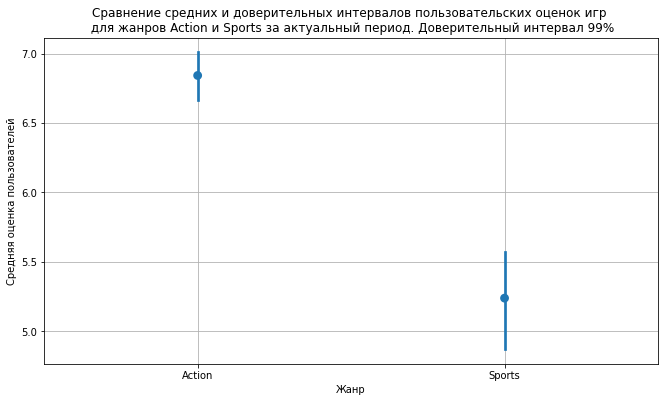

p-value равно: 1.1834308781722751e-20


In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.pointplot(
    x="genre",
    y="user_score",
    data=x,
    dodge=True,
    join=False,
    ci=99,
)
plt.ylabel("Средняя оценка пользователей")
plt.xlabel("Жанр")
plt.grid()
plt.title(
    "Сравнение средних и доверительных интервалов пользовательских оценок игр \n для жанров Action и Sports за актуальный период. Доверительный интервал 99%"
)

plt.show()

s1 = x.loc[x["genre"] == "Action", "user_score"]
s2 = x.loc[x["genre"] == "Sports", "user_score"]

results = scipy.stats.ttest_ind(s1, s2, equal_var=False)

# alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

print("p-value равно:", results.pvalue)

Доверительные интервалы оценок не проникают друг в друга. 

Взяв в качестве критического уровня статистической значимости уровень в 1% (в соответветствии с принципом описаном на https://www.statmethods.ru/stati/vybor-urovnya-znachimosti-pri-proverke-statisticheskikh-gipotez/) или даже 5%, наша гипотеза о равенстве пользовательских оценок двух жанров может быть отвергнута.

В играх типа Action зачастую присуствует  насилие, непристойные сексуальные сцены или грубую ненормативную лексику, что дает, вероятно, больший прилив удовольствия игрокам, которые ставят им более высокие оценки, в отличие от жанра Sports, ограниченного в своих каналах воздействия на игрока. 

Причем, до 2000 года графика не позволяла показать насилие реалистичным, поэтому и средние пользовательских оценок в этот период можно было считать равными.

**Вывод**



Путем проверки гипотез было установлено, что:
1. Гипотезу о равенстве средних пользовательских рейтингов игр на Xbox One и PC отвергнуть не получилось.
2. Гипотеза о равенстве средних пользовательских оценок игр жанров Action и Sports отвергнута.

## Вывод

При планировании рекламной компании на 2017 год, стоит обратить внимание на игры, которые выпускаются на относительно молодых платформах, такие как PS4 и X Box One. Как правило, игры выпущенные на уже укрепившихся, но еще не устаревших платформах имеют большие продажи относительно других игр. 
Исключение составляют игры для платформы PC. Доля рынка этой платформы  оставается небольшой относительно основных лидеров, но стабильной, почти не меняясь со временем.

Стоит смотреть на высокие оценки игр со стороны критиков. Они имеют слабое, но все же какое-никакое влияние на продажи.

Из жанров заслуживающих внимание для продаж подходят шутеры и спортивные игры. И уже во-вторую очередь стоит смотреть на ролевые и платформенные игры.
Если мы не ограничены в количестве предоставляемых на площадке игр, то не стоит забывать, что игры в стиле Action пользуются популярностью, каждая из них дает невысокую прибыль, но за счет своего большого количества могут переплюнуть по общей выручке остальные жанры.

 

Игровые рынки отличаются в зависимости от региона. Самый крупный - Северо-Американский. Далее - Европейский, следом идет Японский. Портрет аудитории на этих рынках схож, за исключением Японии.
Если на первых двух больше акцента стоит делать на стационарные платформы, игры с насилием, обязательно игры маркированные ESRB и вышеперечисленные жанры, то для Японии ставку в рекламной компании стоит делать на игры портативных платформ жанра RPG.